In [28]:
import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

In [29]:
train_audio_path = 'train/train/audio/'
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = 16000)

In [30]:
ipd.Audio(samples, rate=sample_rate)
print(sample_rate)

16000


In [31]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

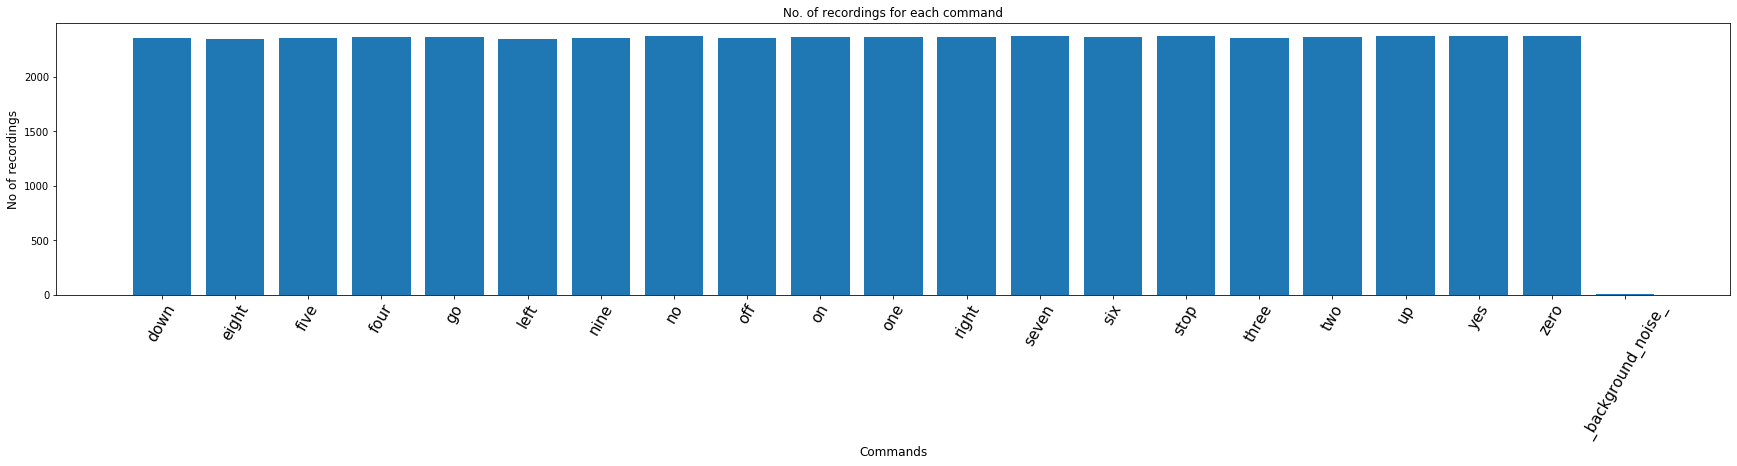

In [32]:
labels=os.listdir(train_audio_path)

#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

labels=["yes", "no", "up", "down", "go", "stop", "one", 'two', 'three',"four", "five", 'six',"seven","eight","nine"]

(array([9.0000e+00, 1.0000e+01, 1.0000e+02, 9.2000e+01, 2.1500e+02,
        3.4800e+02, 5.1100e+02, 4.4200e+02, 7.1300e+02, 3.3088e+04]),
 array([0.3715625 , 0.43440625, 0.49725   , 0.56009375, 0.6229375 ,
        0.68578125, 0.748625  , 0.81146875, 0.8743125 , 0.93715625,
        1.        ]),
 <a list of 10 Patch objects>)

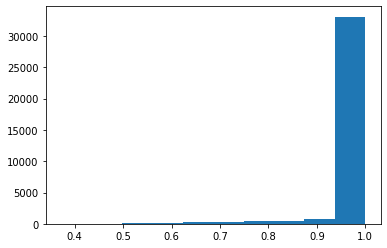

In [33]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [34]:
train_audio_path = 'train/train/audio/'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes
no
up
down
go
stop
one
two
three
four
five
six
seven
eight
nine


In [35]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [36]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

Using TensorFlow backend.


In [37]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

In [38]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.1,random_state=42,shuffle=True)

In [39]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2662, 8)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2662, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 884, 16)           0   

In [40]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [41]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint(filepath='train/model/model{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_acc', verbose=1, save_best_only=False, mode='max',
                     period=5,save_weights_only= False)

In [42]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Train on 28892 samples, validate on 3211 samples
Epoch 1/100
28892/28892 [==============================] - 230s 8ms/step - loss: 2.3568 - accuracy: 0.1706 - val_loss: 2.2224 - val_accuracy: 0.2379
Epoch 2/100
28892/28892 [==============================] - 194s 7ms/step - loss: 1.8070 - accuracy: 0.3739 - val_loss: 1.5338 - val_accuracy: 0.4961
Epoch 3/100
28892/28892 [==============================] - 195s 7ms/step - loss: 1.3778 - accuracy: 0.5408 - val_loss: 1.1538 - val_accuracy: 0.6347
Epoch 4/100
28892/28892 [==============================] - 197s 7ms/step - loss: 1.1269 - accuracy: 0.6288 - val_loss: 1.0777 - val_accuracy: 0.6584
Epoch 5/100
28892/28892 [==============================] - 223s 8ms/step - loss: 0.9799 - accuracy: 0.6779 - val_loss: 0.7625 - val_accuracy: 0.7655

Epoch 00005: saving model to train/model/model05-0.76.hdf5
Epoch 6/100
28892/28892 [==============================] - 255s 9ms/step - loss: 0.8889 - accuracy: 0.7078 - val_loss: 0.7359 - val_accuracy: 0.76

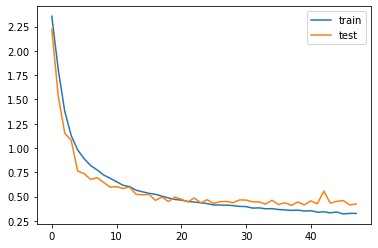

In [43]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [45]:
from keras.models import load_model
model=load_model('train/model/model45-0.45.hdf5')

In [123]:
model.save('my_model.h5')

In [47]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [56]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)
print("Text:",predict(samples))

Audio: three
Text: three


In [121]:
import sounddevice as sd
import soundfile as sf

samplerate = 16000
duration = 1 # seconds
filename = 'micro.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


In [122]:
os.listdir('C:/Users/zaven/Documents/VirusHack')
filepath='C:/Users/zaven/Documents/VirusHack'

#reading the voice commands
samples, sample_rate = librosa.load(filepath + '/' + 'micro.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)  

predict(samples)

'no'

In [110]:
samples2 = librosa.resample(samples2, sample_rate2, 8000)
ipd.Audio(samples2, rate=8000)

In [111]:
predict(samples2)

'no'

In [112]:
len(samples2)

8000